# VCTK Exploration
This notebook investigates the VCTK dataset.
* Basic descriptive analysis (gender, age, accent, region)
* Explore the text transcripts of the speaker utterances
* Listen to original .wav samples
* Listen to the synthesized .wav files created from the WORLD features
* Visualize the pre-computed WORLD features for the samples

## 1) Setup <a id='setup'></a>

In [18]:
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
#from scipy.signal import butter, lfilter
#import scipy.ndimage
import os
import argparse

#import spectrograms.spectrogram_utils as su

#import winsound
import pandas as pd

import glob as gl
from IPython.display import display, HTML

import pydub as pyd
import spectrogram as sp
from utils import generate_merlin_wav

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
vctk_folder = '/home/ubuntu/VCTK-Corpus/'

In [20]:
def plot_spectrogram(wav_data, rate, title="Original Spectrogram"):
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    data = sp.butter_bandpass_filter(wav_data, lowcut, highcut, rate, order=1)
    #data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    #print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

    wav_spectrogram = sp.pretty_spectrogram(wav_data.astype('float64'), fft_size = fft_size, 
                                       step_size = step_size, log = True, thresh = spec_thresh)

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title(title)
    #plt.xlim(0, len(wav_data))
    #plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

In [41]:
def load_pre_calc_features(speaker_id, sample_id, b_valid=False):
    if not b_valid:
        pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features/'
    else:
        pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features_valid/'
    pre_calc_features_file = os.path.join(pre_calc_features_folder, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
    feats = np.load(pre_calc_features_file)
    
    return feats

In [22]:
def play_synthesized_features(feats):
    output_dir = './'
    output_file = 'test.wav'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    generate_merlin_wav(feats['audio_features'],
                        output_dir,
                        output_file,
                        norm_path)

    IPython.display.display(IPython.display.Audio(output_file + '.wav', autoplay=True))
    
    rate, wav_data = wavfile.read(output_file + '.wav')  
    
    return rate, wav_data

## 2) Speaker Info <a id = 'speaker_info'></a>

In [23]:
# this is the reference data file that comes as part of VCTK
speaker_info_file = os.path.join(vctk_folder, 'speaker-info.txt')

In [24]:
# unfortunately the file format is a bit of a mess... decided to do it manually instead
#pd.read_csv(speaker_info_file, delimiter="( )+", engine='python')

In [25]:
# read file contents
f = open(speaker_info_file, 'r')
x = f.readlines()
f.close()

# extract column headers
cols = x[0].lower().split()
num_cols = len(cols)
del x[0]
num_speaker = len(x)

# parse the data line by line
d = dict()

for idx in range(num_speaker):
    this_speaker_id = int(x[idx][:3])
    this_age = int(x[idx][5:7])
    this_gender = x[idx][9]
    residual = x[idx][14:].split()
    this_accent = residual[0]
    this_region = " ".join(residual[1:])

    # add speakers to a dictionary
    d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

# convert to Pandas datafrae
speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)

In [26]:
# display example rows
speaker_info.sort_values('id').head()

,id,age,gender,accents,region
225,225,23,F,English,Southern England
226,226,22,M,English,Surrey
227,227,38,M,English,Cumbria
228,228,22,F,English,Southern England
229,229,23,F,English,Southern England


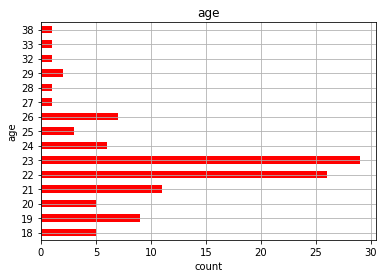

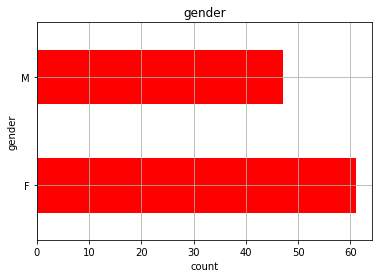

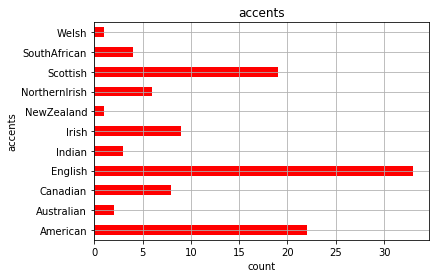

In [27]:
# plot descriptive statistics of speakers
for c in ['age', 'gender', 'accents']:
    plt.figure()
    speaker_info[c].value_counts().sort_index().plot(kind='barh', color='red', grid=True, title=c)
    plt.xlabel('count')
    plt.ylabel(c)

In [28]:
# there are lots of regions - too many to do much with them
pd.DataFrame(speaker_info.groupby(['accents', 'region']).count()['id'])

id
accents       region            
American                       3
              Alabama          1
              California       2
              Chicago          1
              Florida          1
              Indiana          1
              Iowa             1
              Napa             1
              New England      1
              New Jersey       2
              New York         2
              North Carolina   1
              Ohio             1
              Pennsylvania     1
              Philadelphia     1
              San Francisco    1
              Tennessee        1
Australian    English          1
              English Sydney   1
Canadian      Alberta          2
              Hamilton         2
              Montreal         1
              Ontario          1
              Toronto          2
English       Birmingham       1
              Cheshire         1
              Cumbria          1
              Essex            1
              Leicester        1
              London           1
...                           ..
              Suffolk          1
              Surrey           2
              York             1
              Yorkshire        2
Indian                         3
Irish         Athlone          1
              Cork             1
              County Down      1
              Donegal          1
              Dublin           4
              Tipperary        1
NewZealand    English          1
NorthernIrish Belfast          5
              Derry            1
Scottish      Aberdeen         2
              Argyll           1
              Edinburgh        5
              Fife             3
              Galloway         1
              Midlothian       1
              Orkney           1
              Perth            1
              Ross             1
              Selkirk          1
              West Dumfries    1
              West Lothian     1
SouthAfrican  Cape Town        1
              Johannesburg     2
              Pretoria         1
Welsh         Cardiff          1

[70 rows x 1 columns]

## 3) Playing the Raw Files
* Start by identifying a speaker of interest
* Then find an interesting sample
* Then listen to the corresponding .wav file

#### Pick a speaker

In [29]:
# VoiceLoop only uses the speakers with American accents
speaker_info[speaker_info.accents == 'American']

,id,age,gender,accents,region
294,294,33,F,American,San Francisco
297,297,20,F,American,New York
299,299,25,F,American,California
300,300,23,F,American,California
301,301,23,F,American,North Carolina
305,305,19,F,American,Philadelphia
306,306,21,F,American,New York
308,308,18,F,American,Alabama
310,310,21,F,American,Tennessee
311,311,21,M,American,Iowa


In [34]:
# set speaker here
speaker_id = 330

#### Pick a sample

In [35]:
txt_folder = os.path.join(vctk_folder, 'txt/p' + str(speaker_id))
txt_files = sorted(gl.glob(os.path.join(txt_folder, '*.txt')))

s = []
for t in txt_files:
    f = open(t, 'r')
    s.append(os.path.basename(t).replace('.txt', '') + ': ' + f.read())
    #s.append(f.read())
    #print f.read()
    f.close()
    
#pd.DataFrame(s, [os.path.basename(t).replace('.txt', '') for t in txt_files])
display(s)

['p330_001: Please call Stella.',
 'p330_002: Ask her to bring these things with her from the store.',
 'p330_003: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.',
 'p330_004: We also need a small plastic snake and a big toy frog for the kids.',
 'p330_005: She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.',
 'p330_006: When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow.',
 'p330_007: The rainbow is a division of white light into many beautiful colors.',
 'p330_008: These take the shape of a long round arch, with its path high above, and its two ends apparently beyond the horizon.',
 'p330_009: There is , according to legend, a boiling pot of gold at one end.',
 'p330_010: People look, but no one ever finds it.',
 'p330_011: When a man looks for something beyond his reach, his friends say he is looking for the pot of gold at the end of the ra

In [36]:
# set sample here
sample_id = 269

#### Play the audio file

,id,age,gender,accents,region
330,330,26,F,American,


Mary is, as it were, the cause of her mother's death.


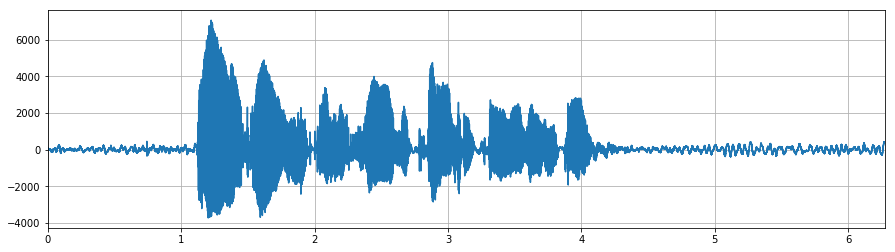

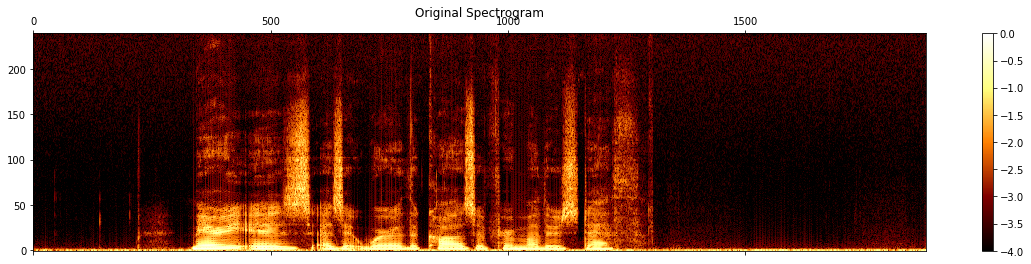

In [37]:
# raw .wav file
wav_file = os.path.join(vctk_folder, 'wav48/p' + str(speaker_id) + '/p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.wav')

# print speaker info
display(speaker_info[speaker_info['id']==speaker_id])

# print text
txt_file = wav_file.replace("wav48", "txt").replace(".wav", ".txt")
f = open(txt_file, 'r')
print(f.read())
f.close()

# play sample
rate, wav_data = wavfile.read(wav_file)    
display(IPython.display.Audio(data=wav_data, rate=rate, autoplay=True))

# plot waveform
plt.figure(figsize=(15,4))
plt.plot(wav_data)
plt.grid(True)
plt.xlim(0, len(wav_data))
plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

# plot spectrogram
plot_spectrogram(wav_data, rate)

## 4) Comparison of Original Samples to Synthesized Samples
* Load the pre-calculated WORLD features for the speaker-sample you listened to in part 3
* Note how the synthesized version compares to the original (some are very good, others less so)
* Plots below show how the waveforms and spectrograms compare. Typically they're similar, but with clear differences.
* The VCTK .wav files typically start with a long silence, which doesn't appear in the WORLD features. We should strip the silence out really to make the .wav files comparable.

In [43]:
# load pre-calculated WORLD features
feats = load_pre_calc_features(speaker_id, sample_id, True)

# synthesize sample from features and listen to the resulting .wav file
rate_synth, wav_data_synth = play_synthesized_features(feats)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete test.wav.wav.


#### Plot waveform

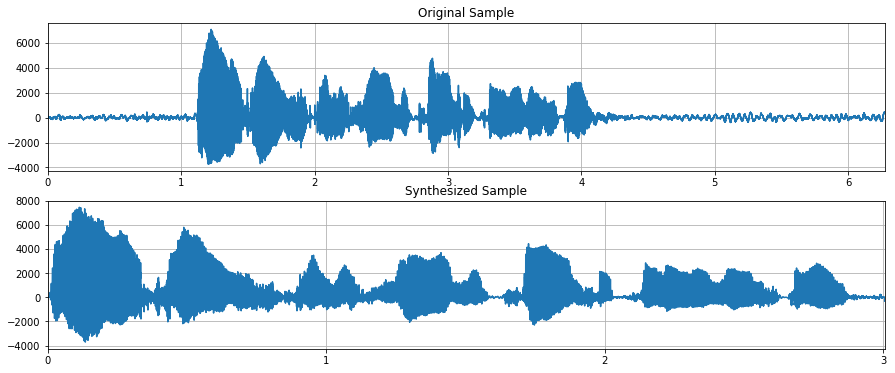

In [44]:
# plot waveform
plt.figure(figsize=(15,6))

# original .wav file
plt.subplot(2,1,1)
plt.plot(wav_data)
plt.grid(True)
plt.xlim(0, len(wav_data))
plt.xticks(range(0,len(wav_data), rate), range(0, np.int(np.ceil(1.0*len(wav_data)/rate))))
plt.title('Original Sample')

# synthesized .wav file
plt.subplot(2,1,2)
plt.plot(wav_data_synth)
plt.grid(True)
plt.xlim(0, len(wav_data_synth))
plt.xticks(range(0,len(wav_data_synth), rate_synth), range(0, np.int(np.ceil(1.0*len(wav_data_synth)/rate_synth))))
plt.title('Synthesized Sample')

plt.show()

#### Plot Spectrogram

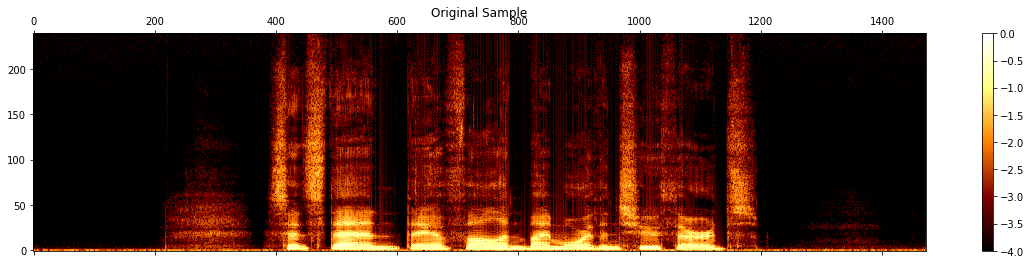

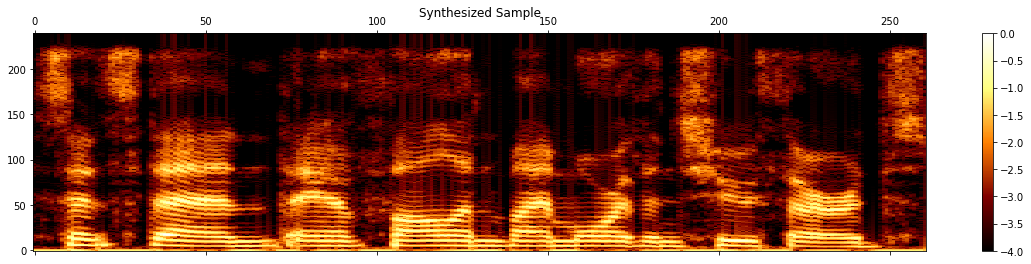

In [84]:
plot_spectrogram(wav_data, rate, 'Original Sample')
plot_spectrogram(wav_data_synth, rate_synth, 'Synthesized Sample')

## 4) Investigate Pre-Computed .npz Files
* It's worth knowing what fields are in the .npz files
* You can see:
    * Original text
    * Phonemes generated from the text
    * Text features
    * WORLD audio features

In [45]:
# list of fields
feats.keys()

['vuv_idx',
 'audio_norminfo',
 'lf0_idx',
 'code2char',
 'text_features',
 'text',
 'durations',
 'audio_features',
 'code2phone',
 'mgc_extent',
 'bap_idx',
 'file_id',
 'phonemes',
 'text_norminfo']

#### Original text

In [46]:
print feats['text']

Mary is, as it were, the cause of her mother's death.


#### Phonemes

In [47]:
# the phoneme codes for this text transcript
feats['phonemes']

array([23, 11, 30, 19, 18, 41, 29,  1, 41, 18, 34, 39, 12, 29, 10,  5, 21,
        0, 41,  2, 38, 33, 16, 12, 23,  2, 10, 12, 41, 33,  9, 11, 35], dtype=int32)

In [48]:
# code-to-phone lookup
print feats['code2phone']
print len(feats['code2phone'])

['aa' 'ae' 'ah' 'ao' 'aw' 'ax' 'ay' 'b' 'ch' 'd' 'dh' 'eh' 'er' 'ey' 'f'
 'g' 'hh' 'i' 'ih' 'iy' 'jh' 'k' 'l' 'm' 'n' 'ng' 'ow' 'oy' 'p' 'pau' 'r'
 's' 'sh' 'ssil' 't' 'th' 'uh' 'uw' 'v' 'w' 'y' 'z']
42


In [49]:
# looked-up phonemes for this text transcript
# i.e. the phonetic version of the original text above
x = feats['phonemes']
#x[x==42] = 0 # for some reason, sometimes there is a phoneme with index=42, which doesn't appear in the dict.
" ".join(feats['code2phone'][x])

'm eh r iy ih z pau ae z ih t w er pau dh ax k aa z ah v ssil hh er m ah dh er z ssil d eh th'

#### Feature Normalisation Info
mean and std for each of the 63 features prior to normalisation

In [50]:
feats['audio_norminfo'].shape

(2, 63)

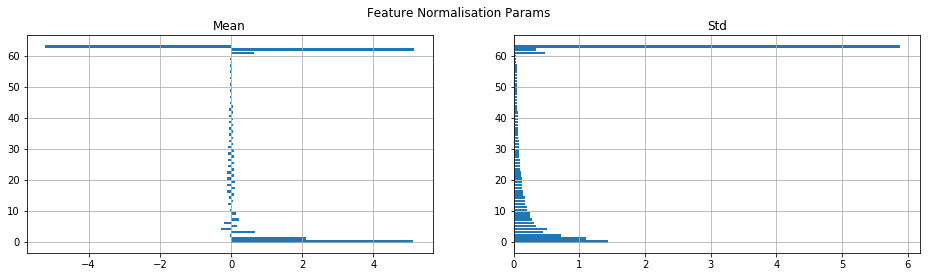

In [51]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.barh(np.linspace(0,63,63), feats['audio_norminfo'][0,:])
plt.grid(True)
plt.title('Mean')

plt.subplot(1,2,2)
plt.barh(np.linspace(0,63,63), feats['audio_norminfo'][1,:])
plt.grid(True)
plt.title('Std')

plt.suptitle('Feature Normalisation Params')
plt.show()

#### WORLD Acoustic Features

In [52]:
# features indices in the audio_feats field
# (mgc features go from 0 - 59)
# not sure about the order of the final 3. vuv and lf0 switched?
print feats['mgc_extent']
print feats['lf0_idx']
print feats['vuv_idx']
print feats['bap_idx']

60
60
61
62


In [53]:
# (# time steps, 63 features)
feats['audio_features'].shape

(602, 63)

In [54]:
# feature time series
#feats['audio_features'][:, feats['lf0_idx']]

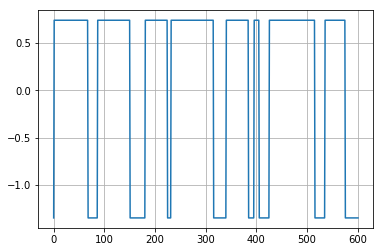

In [55]:
# Question: this is the lf0 index but the feature is clearly vuv
# why are lf0 and vuv the wrong way round?
plt.plot(feats['audio_features'][:, feats['lf0_idx']])
plt.grid('True')

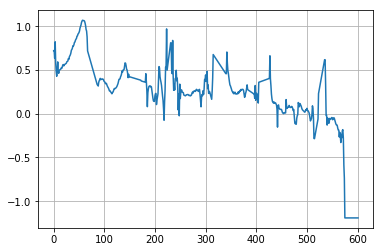

In [56]:
# Is this correct?
plt.plot(feats['audio_features'][:, feats['lf0_idx']+1])
plt.grid('True')

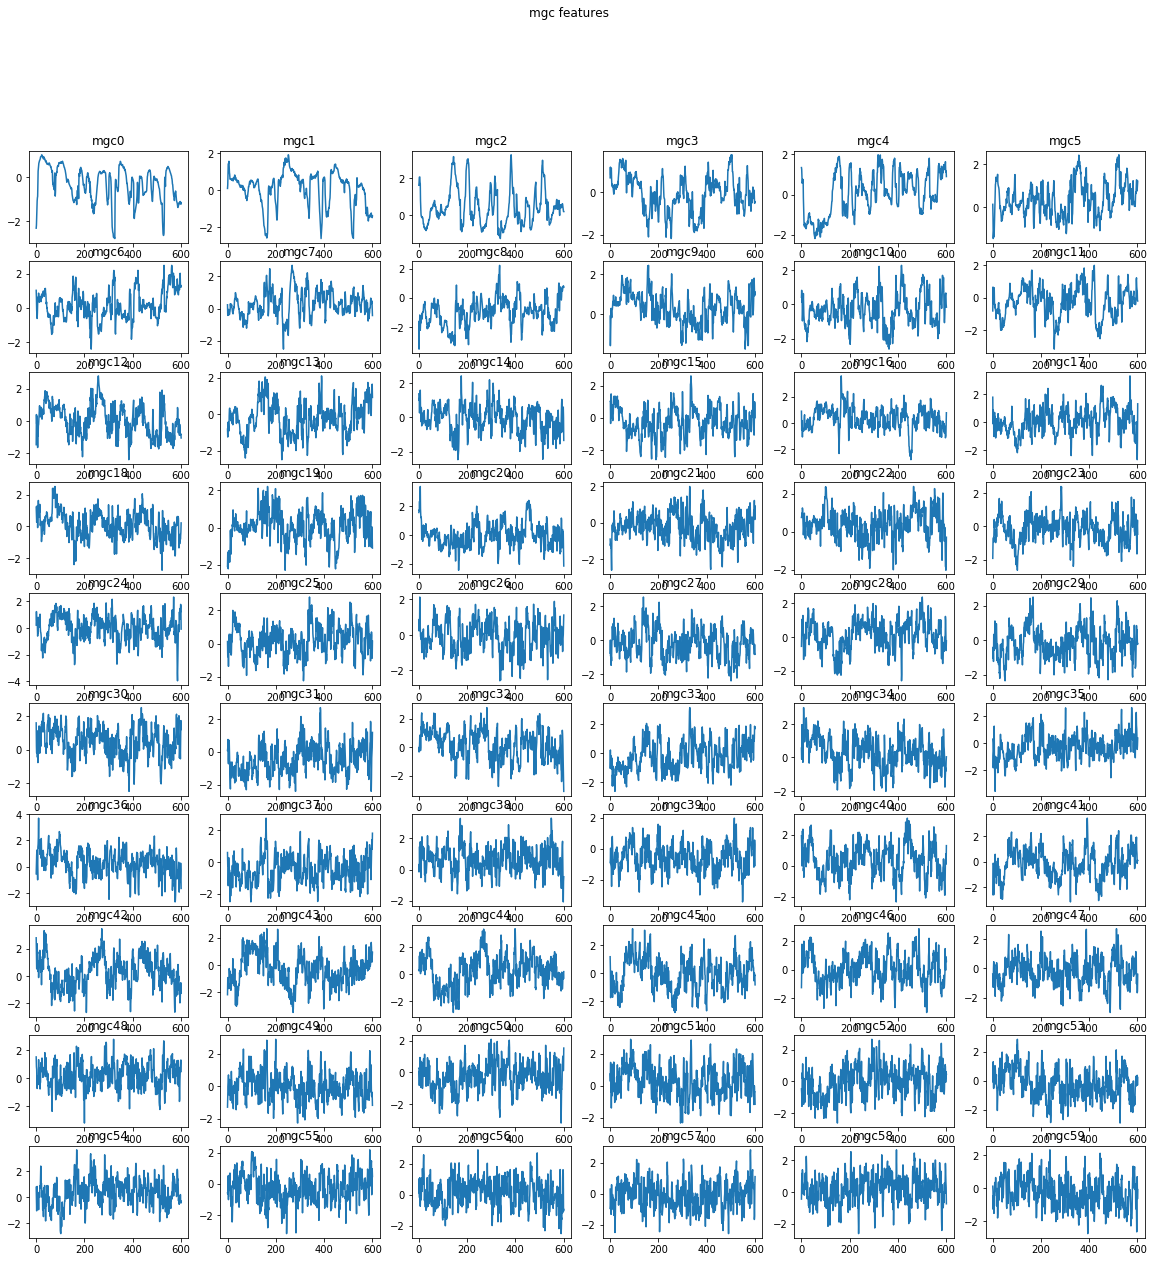

In [57]:
# plot mgc features
plt.figure(figsize=(20,20))
for x in range(60):
    plt.subplot(10, 6, x+1)
    plt.plot(feats['audio_features'][:, x])
    plt.title('mgc' + str(x))

plt.suptitle('mgc features')
plt.show()

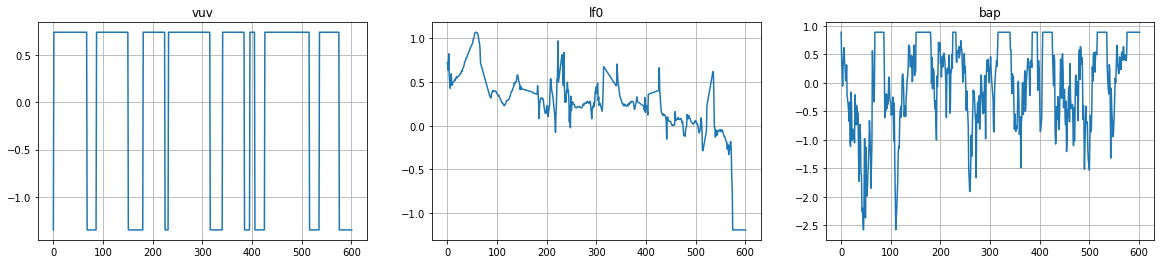

In [58]:
# plot lf0, vuv and bap features
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.plot(feats['audio_features'][:, 60])
plt.title('vuv')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(feats['audio_features'][:, 61])
plt.title('lf0')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(feats['audio_features'][:, 62])
plt.title('bap')
plt.grid(True)

#### Text Features
What are these exactly?

In [70]:
feats['text_features'].shape

(241, 420)

In [71]:
feats['text_features'].max()

39.0

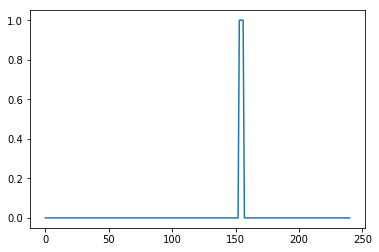

In [72]:
plt.plot(feats['text_features'][:, 10])

#### Text Normalisation Info
Are these used in VoiceLoop?

In [73]:
feats['text_norminfo'].shape

(2, 420)

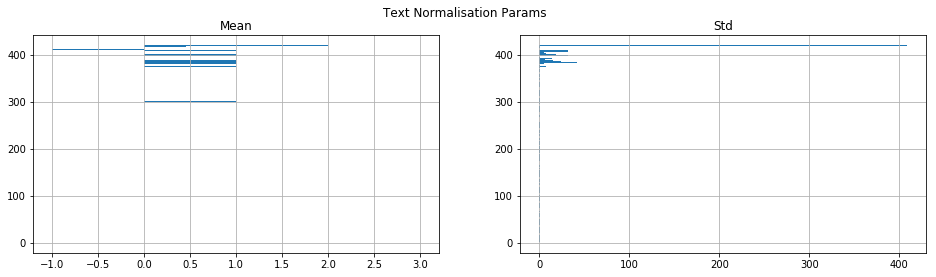

In [74]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.barh(np.linspace(0,420,420), feats['text_norminfo'][0,:])
plt.grid(True)
plt.title('Mean')

plt.subplot(1,2,2)
plt.barh(np.linspace(0,420,420), feats['text_norminfo'][1,:])
plt.grid(True)
plt.title('Std')

plt.suptitle('Text Normalisation Params')
plt.show()

#### Durations
Note used anywhere in the VoiceLoop model.

In [75]:
feats['durations']

array([12, 13,  3, 11, 11,  8,  8,  9, 23, 18,  3, 27,  6,  3,  4, 27, 18,
       39], dtype=int32)

In [76]:
feats['durations'].shape

(18,)

#### Also not used in VoiceLoop

In [77]:
# where is this used
print feats['code2char']
print feats['code2char'].shape

['\t' ' ' '!' "'" ',' '-' '.' '?' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i'
 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y']
(34,)


## 5) Which speakers are in the VoiceLoop dataset?
* VCTK has 109 speakers, but the example VoiceLoop only uses the 22 American speakers
* In fact, one of the American speakers has no text transcript, leaving only 21 useful speakers

In [43]:
# list of speakers with wav files in the VCTK dataset
speaker_folders = [int(g[len(os.path.join(vctk_folder, 'wav48/p')):-1]) for g in gl.glob(os.path.join(vctk_folder, 'wav48/*', ''))]

print len(speaker_folders)

109


In [44]:
# which speaker is missing from the .wav files?
idx_missing = set(speaker_folders) - set(speaker_info['id'])
print idx_missing

set([280])


In [45]:
# which speaker-samples are in the pre-calculated feature dataset that VoiceLoop uses?
pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features/'
feat_files = [os.path.basename(g)[:-4] for g in gl.glob(os.path.join(pre_calc_features_folder, '*.npz'))]

print len(feat_files)

8015


In [46]:
# find unique speakers in the pre-calculated dataset
feat_split = [f.split('_') for f in feat_files]
loop_speaker_ids = np.unique([int(f[0][1:]) for f in feat_split])
print len(loop_speaker_ids)
speaker_info[speaker_info.index.isin(loop_speaker_ids)]

21


,id,age,gender,accents,region
294,294,33,F,American,San Francisco
297,297,20,F,American,New York
299,299,25,F,American,California
300,300,23,F,American,California
301,301,23,F,American,North Carolina
305,305,19,F,American,Philadelphia
306,306,21,F,American,New York
308,308,18,F,American,Alabama
310,310,21,F,American,Tennessee
311,311,21,M,American,Iowa


In [47]:
# which American speaker is missing?
idx_missing_american = set(speaker_info[speaker_info.accents == 'American']['id']) - set(loop_speaker_ids)

speaker_info[speaker_info.index.isin(idx_missing_american)]

# (it turns out they have no text transcripts)

,id,age,gender,accents,region
315,315,18,M,American,New England


## 6) Using PyDub to view frame rate etc.
Not especially useful

In [48]:
song = pyd.AudioSegment.from_wav(wav_file)

In [49]:
print "frame rate: " + str(song.frame_rate)
print "sample width: " + str(song.sample_width)
print "channels: " + str(song.channels)
print "duration (sec): " + str(song.duration_seconds)

frame rate: 48000
sample width: 2
channels: 1
duration (sec): 2.69333333333


## TODO
* Phonemizer